# Index

### - Fuzzy Loss Function

### - Training a Net with FuzzyLoss (ft. pytorch_lightning)

#### a1) ResNet50

#### a2) ResNeXt50_32x4d

#### b) VGG-16

### - ...

### - FICAR System

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn

from fuzzylogic.classes import Domain, Set, Rule
from fuzzylogic.hedges import very
from fuzzylogic.functions import R, S, alpha, triangular

from System import FICAR

# Fuzzy Loss Function

In [2]:
# from FuzzyLoss import FuzzyLoss

class FL_FCS():
    """ Fuzzy Control System for Focal Loss """
    def __init__(self):
        # Definir dominios de inputs y output
        self.balance_deg = Domain("balance_deg", 0, 1, res=0.1)
        self.balance_deg.low = S(0.2, 0.8)
        self.balance_deg.high = R(0.2,0.8)

        self.loss_tminus = Domain("loss_tminus", 0, 2, res=0.01)
        self.loss_tminus.low = S(0.25, 1.75)
        self.loss_tminus.med = triangular(0.25, 1.75, c=1.0)
        self.loss_tminus.high = R(0.25,1.85)

        self.delta_gamma = Domain("Delta_gamma", -0.2, 0.2, res=0.01)
        self.delta_gamma.ne = S(-0.2, -0.0)
        self.delta_gamma.ze = triangular(-0.2, 0.2, c=-0.0)
        self.delta_gamma.po = R(0.0, 0.2)

        # Reglas
        R1 = Rule({(self.balance_deg.low, self.loss_tminus.low): self.delta_gamma.po})
        R2 = Rule({(self.balance_deg.low, self.loss_tminus.med): self.delta_gamma.po})
        R3 = Rule({(self.balance_deg.low, self.loss_tminus.high): self.delta_gamma.ze})
        R4 = Rule({(self.balance_deg.high, self.loss_tminus.low): self.delta_gamma.ze})
        R5 = Rule({(self.balance_deg.high, self.loss_tminus.med): self.delta_gamma.ne})
        R6 = Rule({(self.balance_deg.high, self.loss_tminus.high): self.delta_gamma.ne})
        self.rules = R1 | R2 | R3 | R4 | R5 | R6
    
    def evaluate(self, bd, lt):
        """ return how much to change current gamma in terms of:
            - current class' balance degree
            - current focal loss for current class, obtained during step
        """
        values = {self.balance_deg: bd, self.loss_tminus: lt}
        delta_gamma = self.rules(values)
        return delta_gamma

    
class FuzzyLoss(torch.nn.CrossEntropyLoss):
    """ Fuzzy-Adaptive Focal Loss """
    def __init__(self, gamma=0, class_sizes=[1,1], alpha=None):
        super(FuzzyLoss, self).__init__()
        
        self.class_sizes = np.array(class_sizes)
        self.n_classes = len(self.class_sizes)
        # balance degree of each class
        self.balance_deg = dict((i, class_sizes[i]/max(class_sizes)) for i in range(len(class_sizes)))
        
        # initially all classes with same gamma
        self.gamma = dict((i, gamma) for i in range(self.n_classes))
        self.alpha = alpha
        
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        
        self.FCS = FL_FCS()

    def forward(self, input_, target):
        if input_.dim()>2:
            input_ = input_.view(input_.size(0),input_.size(1),-1)  # N,C,H,W => N,C,H*W
            input_ = input_.transpose(1,2)    # N,C,H*W => N,H*W,C
            input_ = input_.contiguous().view(-1,input_.size(2))   # N,H*W,C => N*H*W,C
        ground_truth = target
        target = target.view(-1,1)

        logpt = F.log_softmax(input_, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type()!=input_.data.type():
                self.alpha = self.alpha.type_as(input_.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        
        loss = torch.Tensor([0.0]*len(pt))
        for i, (pt_, logpt_) in enumerate(zip(pt, logpt)):
            curr_class = ground_truth[i].item()
            # la loss de cada instancia del batch evaluada con su gamma respectiva
            loss[i] = -1 * (1-pt_)**self.gamma[curr_class] * logpt_
        
        # tanto la media como el loss para cada _Instancia_
        return loss.mean(), loss
        
    def update_hyperparams(self, current_losses, targets, alpha=None):
        """ update each class' gamma based on:
            - that class's balance degree
            - that class's loss in current step
        """
        self.alpha = alpha
        if len(current_losses) != len(targets): raise ValueError('current loss must be same length as targets!')
        
        # obtener loss media para cada clase
        class_loss = {}
        targets = targets.cpu().numpy()
        for i in range(len(targets)):
            if targets[i] not in class_loss:
                class_loss[targets[i]] = np.array([current_losses[i].item()])
            else:
                class_loss[targets[i]] = np.append(class_loss[targets[i]], current_losses[i].item())
        for k in class_loss.keys():
            class_loss[k] = class_loss[k].mean()
        
        for i in range(self.n_classes):
            delta_gamma = self.FCS.evaluate(self.balance_deg[i], class_loss[i])
            self.gamma[i] += delta_gamma

In [3]:
y_true = torch.tensor([0,  1], dtype=torch.int64)
y_pred = torch.tensor([[.7 , 0 , 0 ,0 ,  .3], [0, 0.9, 0, 0.1, 0]])

print('DF-CELoss : ', torch.nn.CrossEntropyLoss()(y_pred, y_true).numpy())

fuzzyloss = FuzzyLoss(gamma=0., class_sizes=[500,5000])
loss, losses = fuzzyloss(y_pred, y_true)
print('FuzzyLoss : ', loss.numpy())
fuzzyloss.update_hyperparams(losses, y_true)

DF-CELoss :  1.0661571
FuzzyLoss :  1.0661571


# Training a Net with FuzzyLoss (ft. `pytorch_lightning`)

## a1) ResNet50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NTrain: 86752 // NVal: 10976


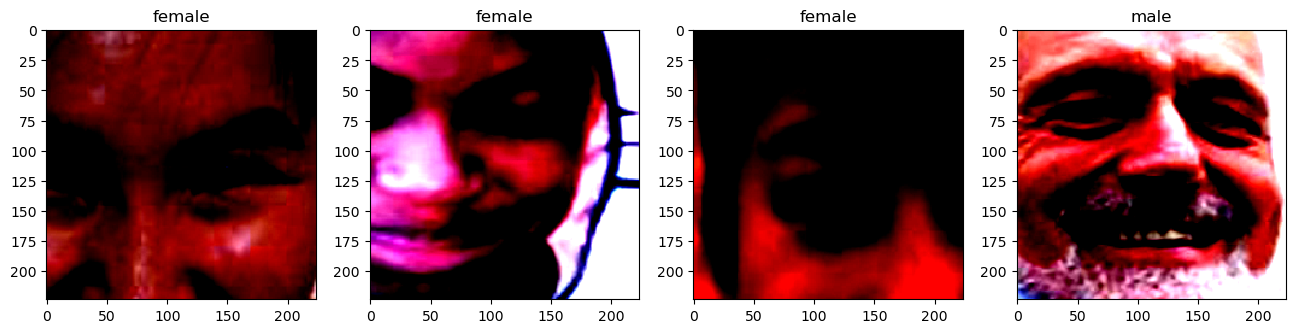

In [5]:
from System import get_dataloaders_from_path, plot_images_sample

dataloaders, dataset_sizes, class_names = get_dataloaders_from_path('../data/FairFace/')
plot_images_sample(dataloaders['train'])
print('NTrain:', len(dataloaders['train'])*32, '// NVal:', len(dataloaders['val'])*32) # 32-img batches

In [6]:
from torchvision.models import resnet50

EPOCHS = 30

class ResNetCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.fuzzyloss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes).cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        mean_loss, losses = self.fuzzyloss(logits, y)
        
        # Update focal loss with Fuzzy Control System
#         self.fuzzyloss.update_hyperparams(losses, y)
        
        return mean_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.SGD(self.model[0].fc.parameters(), lr=0.001, momentum=0.9)
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(dataloaders['train']),
                                epochs=EPOCHS,
        )}

In [ ]:
model = ResNetCustom(gamma=0., class_sizes=[51778,45920])
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
trainer.fit(model, dataloaders['train'])

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | ResNet    | 23.5 M
1 | fuzzyloss | FuzzyLoss | 0     
--------------

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.save_checkpoint("saves/resnet50_FairFace_focalloss_transfer.pt")

Now we can reload it w/o training:

In [ ]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNetCustom.load_from_checkpoint("saves/resnet50_FairFace_focalloss_transfer.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

In [ ]:
from tqdm.autonotebook import tqdm

true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

## a2) ResNeXt50_32x4d

In [29]:
from torchvision.models import resnext50_32x4d

class ResNext(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[]):
        super().__init__()
        self.n_classes = len(class_sizes)
        self.model = resnext50_32x4d(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
        self.loss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.005)
        return torch.optim.SGD(self.model.fc.parameters(), lr=0.001, momentum=0.9)

In [30]:
model3 = ResNext(gamma=0., class_sizes=[1,1])
trainer3 = pl.Trainer(gpus=1, max_epochs=15, devices=1, accelerator="gpu")
trainer3.fit(model3, dataloaders['train'])

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | ResNet    | 23.0 M
1 | loss  | FuzzyLoss | 0     
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [31]:
trainer3.save_checkpoint("saves/resneXt_utk_focalloss.pt")

In [33]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNext.load_from_checkpoint("saves/resneXt_utk_focalloss.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

from tqdm.autonotebook import tqdm
true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())
    
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

  0%|          | 0/220 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.856     0.676     0.755      3621
           1      0.718     0.879     0.790      3401

    accuracy                          0.774      7022
   macro avg      0.787     0.777     0.773      7022
weighted avg      0.789     0.774     0.772      7022



## b) VGG-16

In [6]:
from torchvision.models import vgg16

class VGGCustom(pl.LightningModule):
    def __init__(self, gamma=0., class_sizes=[]):
        super().__init__()
        self.model = vgg16(num_classes=10)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.loss = FuzzyLoss(gamma=gamma, class_sizes=class_sizes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.005)

In [7]:
model2 = VGGCustom(gamma=0., class_sizes=[1,1])
trainer2 = pl.Trainer(gpus=1, max_epochs=5, devices=1, accelerator="gpu")
trainer2.fit(model2, dataloaders['train'])

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | VGG       | 134 M 
1 | loss  | FuzzyLoss | 0     
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
trainer2.save_checkpoint("saves/vgg16_utk_focalloss.pt")

In [9]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = VGGCustom.load_from_checkpoint("saves/vgg16_utk_focalloss.pt", map_location="cuda", gamma=0., class_sizes=[1,1])

from tqdm.autonotebook import tqdm
true_y, pred_y = [], []
for batch in tqdm(iter(dataloaders['val']), total=len(dataloaders['val'])):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())
    
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

  0%|          | 0/220 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.516     1.000     0.680      3621
           1      0.000     0.000     0.000      3401

    accuracy                          0.516      7022
   macro avg      0.258     0.500     0.340      7022
weighted avg      0.266     0.516     0.351      7022



/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# FICAR System

In [11]:
system = FICAR(n_classes=2, class_names=['male', 'female'])
system.train("dummyDL")

P(0,1)-> Fit with pair ('male', 'female')


In [12]:
y_pred = system.predict('dummyIns')
print(system.decisions)
print(y_pred)

[[0.         0.41190704]
 [0.58809296 0.        ]]
male
